In [1]:
from utils.imports import *
from utils.preprocessing_funcs import model_evaluation
from sklearn.model_selection import  StratifiedKFold

In [ ]:
data_path = 'data'
DATA_ROOT = Path(data_path)

# Accessing stored features and labels for train
X = np.load(DATA_ROOT / "extracted_features/X_train.npy")
y = np.load(DATA_ROOT / "labels/y_train.npy")
X_test = np.load(DATA_ROOT / "extracted_features/X_test.npy")

# GLOBAL VARIABLES
random_state = 42

# ------------------------------- Extracted features -----------------------------------------------#
channels = ['FP1', 'FP2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'FZ', 'CZ', 'PZ']
features = [
    "rms", "linelen", "hj_mob", "hj_cmp", "spec_ent",
    "alpha_pow", "beta_pow", "theta_pow", "gamma_pow",
    "rel_alpha", "rel_theta", "theta_alpha_ratio"
]
n_features = len(features)
n_channels = len(channels)

feature_names = [f"{ch} - {ft}" for ch in channels for ft in features]

# ----------------------------------------------------------------------------------------------------------

# --------------------------- Generate ids for test samples for submission ------------------------------------------#
# Test-ids
clips_te = pd.read_parquet(DATA_ROOT / "test/segments.parquet")
df = clips_te.reset_index()  # Bring multi-index into columns
# Create new 'id' column by joining index parts with '_'
df["id"] = df["patient"] + "_" + df["session"] + "_" + df["segment"].astype(str)
test_ids = df['id']

### 0. ML baseline model

In [160]:
model = GradientBoostingClassifier(n_estimators=400, learning_rate=0.1,
                               max_depth=8, subsample=1,
                               random_state=random_state)

f1, std = model_evaluation(model, X = X, y = y,n_features= n_features, n_splits = 5,
                                    oversampler=True,
                                    random_state=random_state,
                                    return_importances = False,
                                    show_matrix=False)

CV folds: 100%|██████████| 5/5 [3:51:47<00:00, 2781.49s/it]  

 F1: 0.8933 ± 0.0036


In [ ]:
from lightgbm import LGBMClassifier

model = LGBMClassifier(
    n_estimators=400,
    learning_rate=0.1,
    max_depth=8,
    subsample=1.0,
    random_state=random_state
)

f1, std = model_evaluation(
    model, X=X, y=y, n_features=n_features, n_splits=5,
    oversampler=True,
    random_state=random_state,
    return_importances=False,
    show_matrix=False
)

In [ ]:
# -------------------------------- Submission generation -----------------------------------------------#

#  ------------- Train with all training data -------------------#
# 1. Preprocessing: scale training set, then test
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_test = scaler.transform(X_test)

# 2. Oversample training only 
sampler = RandomOverSampler(random_state=42)
X_scaled, y_scaled = sampler.fit_resample(X_scaled, y)

# Fit model
model.fit(X_scaled, y_scaled)

# -------------- Generate predictions for test ----------------#

# Generate predictions for X_test
predictions = model.predict(X_test) 

#  Combine with IDs
submission_df = pd.DataFrame({
    "id": test_ids,
    "label": predictions
})

# Save to CSV (no index)
submission_df.to_csv("submission.csv", index=False)
print(" Submission file saved as 'submission.csv'")

### 1. Model evaluation

- Optimal RandomForest: 
    - Number trees: 400 
    - Depth: 8
- Approach:
    - Robust scaling (gave same performance as removing outliers first with Isolation Forest)
    - Oversampling on train set (much better performance!)
- Evaluation with:
    - Stratified KFold: to obtain more realistic F1-score for validation set -> Ensures balance with minority class
    - F1-score; macro average

### 2. Feature importance

In [38]:
model = RandomForestClassifier(n_estimators= 400, max_depth=8, random_state=random_state)


f1, std, importance_mean, importance_std = model_evaluation(model, X = X, y = y,n_features= n_features, n_splits = 5,
                                    oversampler=True,
                                    random_state=random_state,
                                    return_importances = True,
                                    show_matrix=False)

CV folds: 100%|██████████| 5/5 [06:02<00:00, 72.58s/it]

 F1: 0.8293 ± 0.0083


### Feature importance

**Top-N important features**

In [40]:
top_k = 10
importance_mean_flat = importance_mean.flatten() # (19,12) -> (228)
importance_std_flat = importance_std.flatten()

top_indices = np.argsort(importance_mean_flat)[-top_k:][::-1]

top_indices = top_indices.flatten()
print("Top-10 features:")
for i in top_indices:
    print(f"{feature_names[i]} | Importance: {importance_mean_flat[i]:.4f} ± {importance_std_flat[i]:.4f}")

Top-10 features:
O2 - theta_pow | Importance: 0.0414 ± 0.0006
T6 - theta_pow | Importance: 0.0391 ± 0.0011
F3 - theta_pow | Importance: 0.0253 ± 0.0012
C3 - theta_pow | Importance: 0.0222 ± 0.0018
CZ - theta_pow | Importance: 0.0202 ± 0.0028
PZ - theta_pow | Importance: 0.0185 ± 0.0012
T6 - beta_pow | Importance: 0.0173 ± 0.0007
FZ - theta_pow | Importance: 0.0172 ± 0.0019
P3 - theta_pow | Importance: 0.0154 ± 0.0017
FP2 - theta_pow | Importance: 0.0148 ± 0.0008


**Insight**
- **Feature type**
    - 9 out of 10 features are ```theta_pow``` -> **the most discriminative feature type for seizure vs. non-seizure detection in your model**.
        - Supported by literature: theta band activity (4-8  Hz) is often altered in seizures.
        - Studies have shown that theta activity can be both increased and decreased in epilepsy, depending on the brain region, the state (interictal, pre-ictal, ictal, post-ictal), and the specific type of epilepsy.



**Spatial distribution**
- The widespread importance of theta power suggests that seizure-related changes involve many brain regions (not localized).
- The most important ones:


    - **Temporal Lobe (T6)**:
        -  Well-established role of the temporal lobe in many types of epilepsy, particularly Temporal Lobe Epilepsy (TLE). 
        -  The temporal lobe (includes hippocampus and amygdala) is often the origin (seizure onset zone) or involved in the propagation of seizures.   
    - **Frontal Lobe (F3, FZ, FP2)**
        -  The frontal lobe is involved in executive functions and attention, 
        - Theta activity in this region is often affected in epilepsy patients. 
    - **Central Regions (C3, CZ)**
        -  The central areas are involved in motor and sensory processing. 
        - Chages could reflect the spread of seizure activity across the brain.
        - Similar manifestation as parietal seizures (see below).
    - **Parietal Regions (PZ, P3)**
        - The parietal lobe is involved in sensory integration and spatial awareness. 
        - Seizures arising in the parietal lobe are less common than those in the temporal or frontal lobes.
        - Parietal lobe seizures often involve sensory symptoms, such as tingling, numbness, pain, or a sensation of movement or distortion of body parts; and spatial disorientation.
    - **Occipital Region (O2)**
        -  Primarily associated with visual processing, 
        - Can be involved in seizures, particularly those with visual auras or manifestations.
 




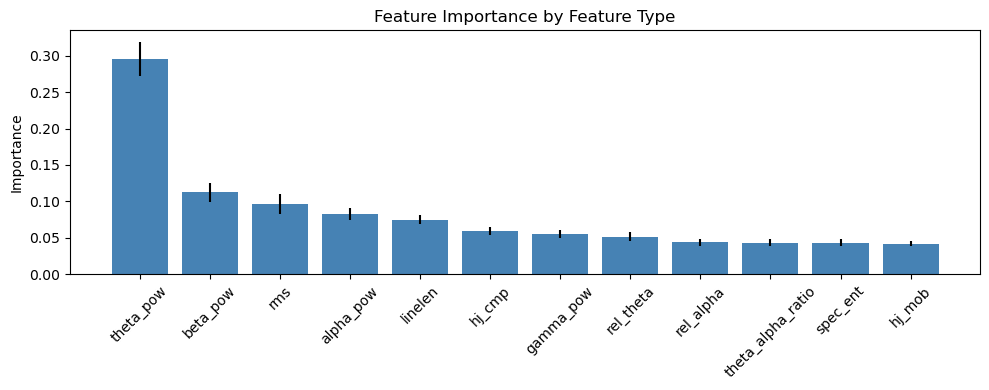

In [43]:
# Sum across channels (cols.) -> n_features
feature_type_importance = importance_mean.sum(axis=0)
feature_type_std = importance_std.sum(axis=0)

# Sort indices by descending importance
sorted_idx = np.argsort(feature_type_importance)[::-1]

# Apply sorting 
sorted_features = [features[i] for i in sorted_idx]
sorted_importance = feature_type_importance[sorted_idx]
sorted_std = feature_type_std[sorted_idx]

# Plot
plt.figure(figsize=(10, 4))
plt.bar(sorted_features, sorted_importance, yerr=sorted_std, color='steelblue')
plt.title("Feature Importance by Feature Type")
plt.xticks(rotation=45)
plt.ylabel("Importance")
plt.tight_layout()
plt.show()


**Electrode importance**

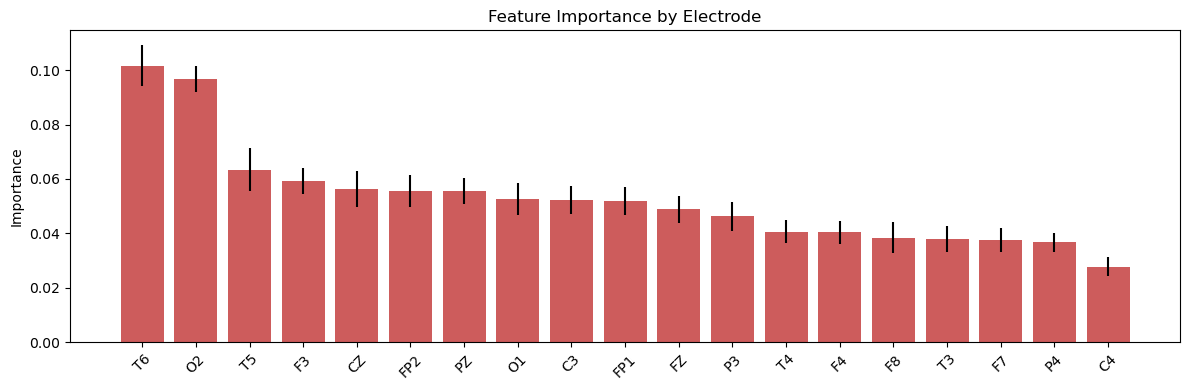

In [42]:
# Sum across features (rows) -> n_channels
channel_importance = importance_mean.sum(axis=1)
channel_std = importance_std.sum(axis=1)

# Sort indices by descending importance
sorted_idx = np.argsort(channel_importance)[::-1]

# Apply sorting 
sorted_channels = [channels[i] for i in sorted_idx]
sorted_importance = channel_importance[sorted_idx]
sorted_std = channel_std[sorted_idx]


plt.figure(figsize=(12, 4))
plt.bar(sorted_channels, sorted_importance, yerr=sorted_std, color='indianred')
plt.title("Feature Importance by Electrode")
plt.xticks(rotation=45)
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

### Analysis on diff. mean for feature type and electrode

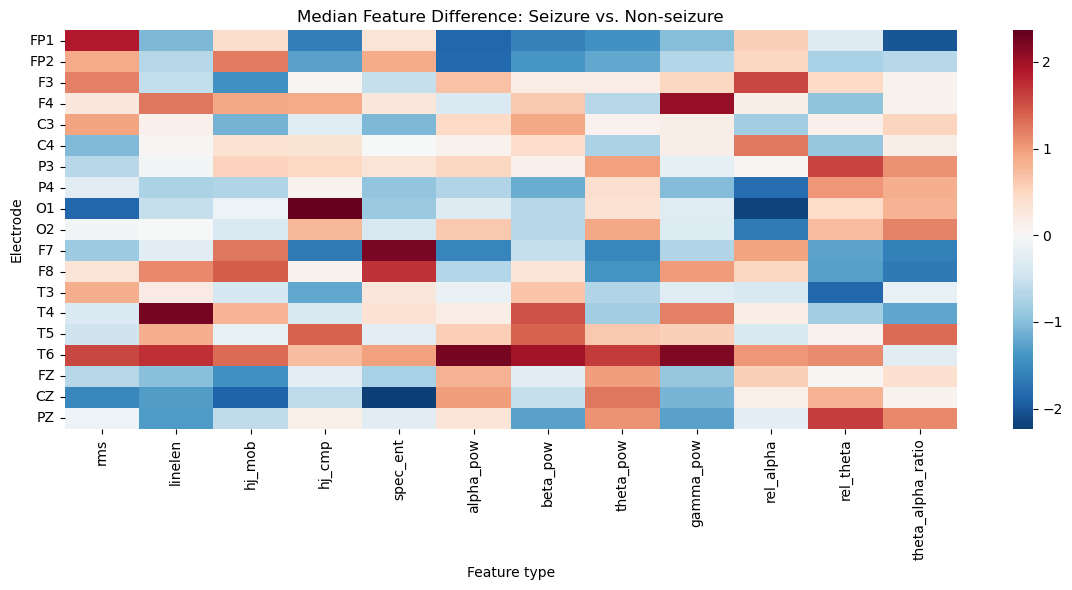

In [151]:

# Reshape X  to analyze features by electrode and feature type
X_reshaped = X.reshape(-1, 19, 12) # (n_samples, 228) -> (n_samples, 19,12)

# Mask samples by class
seizure_X = X_reshaped[y == 1]
non_seizure_X = X_reshaped[y == 0]


# Compute medians
median_seizure = np.median(seizure_X, axis=0)
median_non_seizure = np.median(non_seizure_X, axis=0)

# Difference matrix
diff_matrix = median_seizure - median_non_seizure

# Scale (otherwise features with larger magnitude dominate (linelen))
scaler = StandardScaler()
diff_matrix_scaled = scaler.fit_transform(diff_matrix)


# ---------------------------- Plot heatmap ----------------------------------------------#
plt.figure(figsize=(12, 6))
sns.heatmap(diff_matrix_scaled, xticklabels=features, yticklabels=channels, cmap="RdBu_r", center=0)
plt.title("Median Feature Difference: Seizure vs. Non-seizure")
plt.xlabel("Feature type")
plt.ylabel("Electrode")
plt.tight_layout()
plt.show()

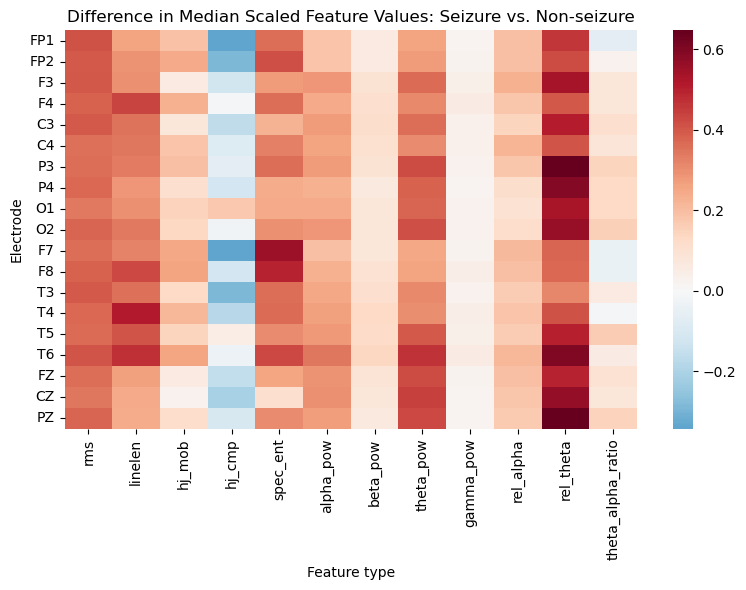

In [152]:

# Reshape X
X_reshaped = X.reshape(-1, n_channels, n_features)


# ---------------------------------------- Scale features --------------------------------------------------------------------------#
# Initialize the scaler
scaler = StandardScaler()

# Scale each feature type across all samples
X_scaled = np.zeros_like(X_reshaped, dtype=float)
for feature_index in range(n_features):
    feature_data = X_reshaped[:, :, feature_index].reshape(-1, 1)
    X_scaled[:, :, feature_index] = scaler.fit_transform(feature_data).reshape(-1, n_channels)


# ------------------------------------ Compute median differences ------------------------------------------------------#
# Mask samples by class
seizure_X_scaled = X_scaled[y == 1]
non_seizure_X_scaled = X_scaled[y == 0]

# Compute medians of the data
median_seizure_scaled = np.median(seizure_X_scaled, axis=0)
median_non_seizure_scaled = np.median(non_seizure_X_scaled, axis=0)

# Difference matrix of the scaled medians
diff_matrix_scaled = median_seizure_scaled - median_non_seizure_scaled

# ---------------------------- Plot heatmap ----------------------------------------------#
plt.figure(figsize=(8, 6))
sns.heatmap(diff_matrix_scaled, xticklabels=features, yticklabels=channels, cmap="RdBu_r", center=0)
plt.title("Difference in Median Scaled Feature Values: Seizure vs. Non-seizure")
plt.xlabel("Feature type")
plt.ylabel("Electrode")
plt.tight_layout()
plt.show()

**Analysis of heatmap**

- Each cell represents the median difference in a specific feature between seizure and non-seizure samples for a given electrode:
    - Red: higher during seizures
    - Blue: lower during seizures

**Insights**
- Most features show consistently higher median values during seizures.



- ```theta-pow```: was the feature type with the most importance from Random Forest classifier

**Let's plot features distribution of ```theta-pow``` across both groups** to verify results

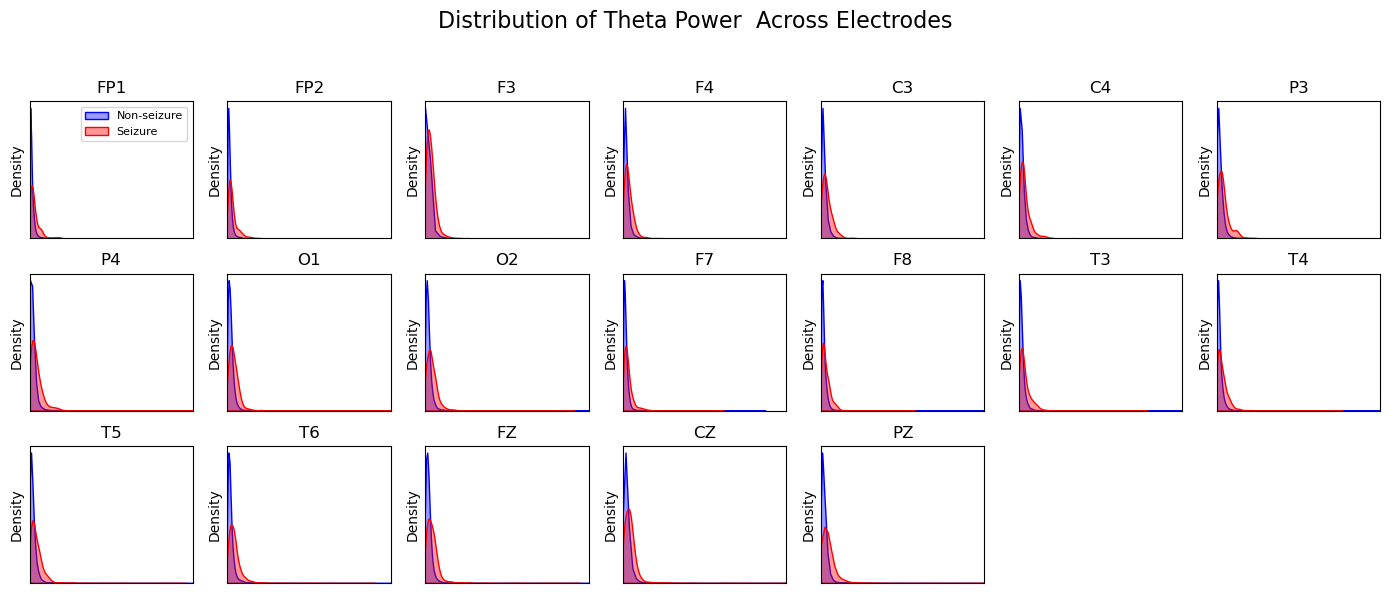

In [145]:
# Feature index for theta_pow
theta_idx = features.index("theta_pow")

plt.figure(figsize=(14, 6))

for ch_idx, ch in enumerate(channels):
    plt.subplot(3, 7, ch_idx + 1)  # 3 rows × 7 columns = 21 slots
    
    # Extract values for this channel and theta feature
    vals_non_seiz = X_reshaped[y == 0, ch_idx, theta_idx]
    vals_seiz     = X_reshaped[y == 1, ch_idx, theta_idx]

    sns.kdeplot(vals_non_seiz, label="Non-seizure", fill=True, color="blue", alpha=0.4)
    sns.kdeplot(vals_seiz, label="Seizure", fill=True, color="red", alpha=0.4)

    plt.title(ch)
    plt.xticks([])
    plt.yticks([])
    if ch_idx == 0:
        plt.legend(fontsize=8)
    plt.xlim([0,5])

plt.suptitle("Distribution of Theta Power  Across Electrodes", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


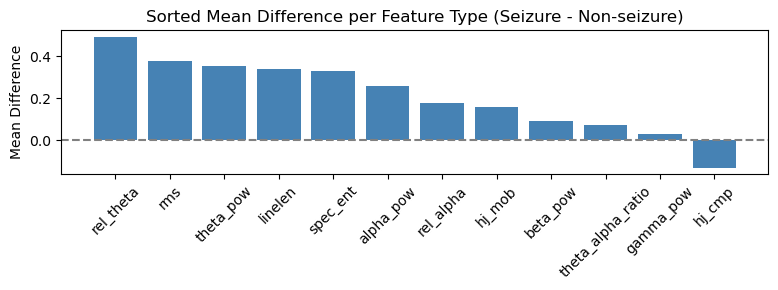

In [146]:
# Average difference per feature type (across electrodes)
feature_means = diff_matrix_scaled.mean(axis=0)

# Sort values and labels
sorted_idx_feat = np.argsort(feature_means)[::-1]
sorted_features = [features[i] for i in sorted_idx_feat]
sorted_values_feat = feature_means[sorted_idx_feat]

plt.figure(figsize=(8, 3))
plt.bar(sorted_features, sorted_values_feat, color='steelblue')
plt.xticks(rotation=45)
plt.title("Sorted Mean Difference per Feature Type (Seizure - Non-seizure)")
plt.axhline(0, color="gray", linestyle="--")
plt.ylabel("Mean Difference")
plt.tight_layout()
plt.show()



**Insights**
- Seizure segments show an **increase across most EEG features**, indicating more intense or irregular brain activity.


> Exception: Hjorth complexity (hj_cmp) decreases, suggesting less signal variability in second-order derivatives, possibly due to rhythmic seizure discharges.

- High-frequency activity (30–50 Hz, gamma_pow) does not differ strongly, implying gamma power may not be a strong seizure indicator in this context.

- Increases occur across nearly all electrode locations, indicating broad spatial involvement rather than strict localization.
    - However, some temporal and parietal areas (e.g. T6, P3, T5) show slighly stronger increases in activity.

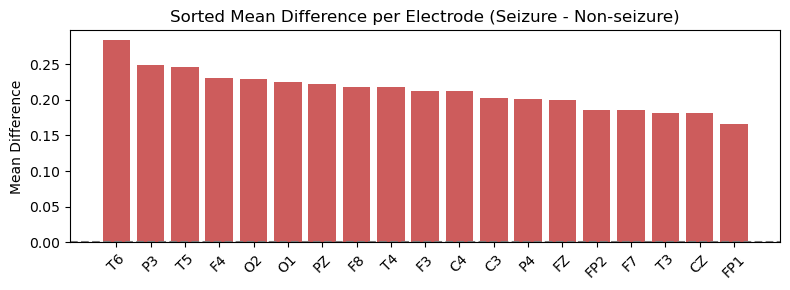

In [147]:
# Average difference per electrode (across features)
electrode_means = diff_matrix_scaled.mean(axis=1)

# Sort values and labels
sorted_idx_ch = np.argsort(electrode_means)[::-1]
sorted_channels = [channels[i] for i in sorted_idx_ch]
sorted_values_ch = electrode_means[sorted_idx_ch]

plt.figure(figsize=(8, 3))
plt.bar(sorted_channels, sorted_values_ch, color="indianred")
plt.xticks(rotation=45)
plt.title("Sorted Mean Difference per Electrode (Seizure - Non-seizure)")
plt.axhline(0, color="gray", linestyle="--")
plt.ylabel("Mean Difference")
plt.tight_layout()
plt.show()


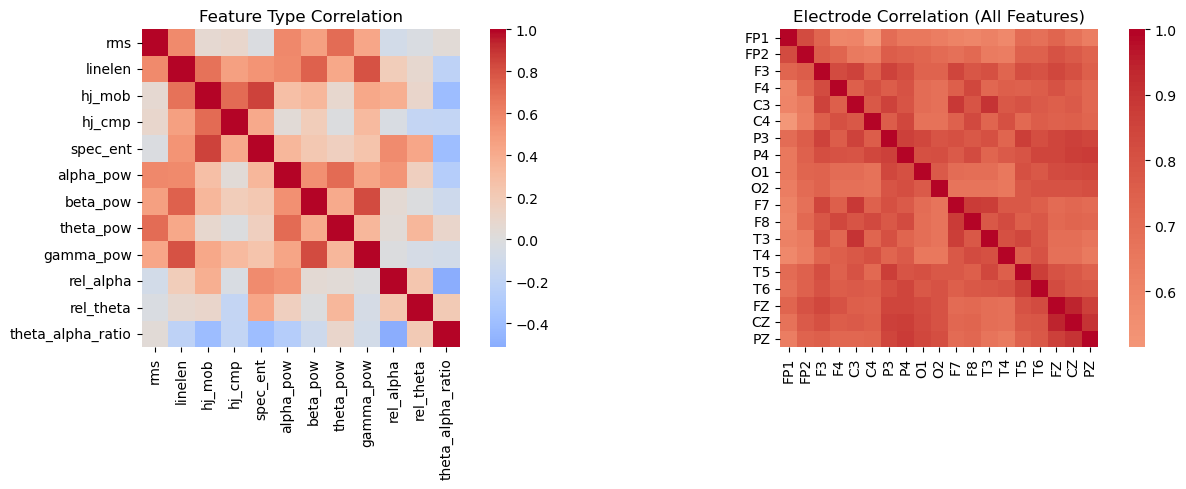

In [148]:
# -------------------------------------------- Correlation ----------------------------------------------------#
# Input: (N,M) -> N: variables, M: observations

# 1. Feature type correlation (averaged over electrodes)
X_features = X_reshaped.mean(axis=1)  # shape:  (samples, 19, 12) -> (samples, 12 features) 
feature_corr = np.corrcoef(X_features.T) # (samples, 12 features) -> (12 features, samples)

# 2. Electrode correlation (flattened features over all samples)
X_electrodes = X_reshaped.transpose(0, 2, 1).mean(axis=1)  # (samples, 19, 12) -> (samples, 12, 19) -> (samples, 19) 
electrode_corr = np.corrcoef(X_electrodes.T)

# ------------- Plots ----------------
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Feature correlation heatmap
sns.heatmap(feature_corr, xticklabels=features, yticklabels=features,
            cmap="coolwarm", center=0, square=True, ax=axes[0])
axes[0].set_title("Feature Type Correlation")

# Electrode correlation heatmap
sns.heatmap(electrode_corr, xticklabels=channels, yticklabels=channels,
            cmap="coolwarm", center=0, square=True, ax=axes[1])
axes[1].set_title("Electrode Correlation (All Features)")

plt.tight_layout()
plt.show()

Top 10 correlated electrode pairs:

 FZ - CZ  | Correlation: 0.9404
 CZ - PZ  | Correlation: 0.9042
 C3 - T3  | Correlation: 0.8983
 C3 - F7  | Correlation: 0.8856
 F7 - F8  | Correlation: 0.8764
 P4 - PZ  | Correlation: 0.8755
 P4 - CZ  | Correlation: 0.8727
 F7 - T3  | Correlation: 0.8723
 P3 - T5  | Correlation: 0.8705
 T5 - T6  | Correlation: 0.8673

Bottom 10 least correlated electrode pairs:
FP1 - O2  | Corr: 0.6332
FP1 - PZ  | Corr: 0.6306
FP2 - C4  | Corr: 0.6288
FP1 - T3  | Corr: 0.6153
FP1 - F7  | Corr: 0.6056
FP1 - C3  | Corr: 0.5944
FP1 - F4  | Corr: 0.5937
FP1 - F8  | Corr: 0.5870
FP1 - T4  | Corr: 0.5797
FP1 - C4  | Corr: 0.5142


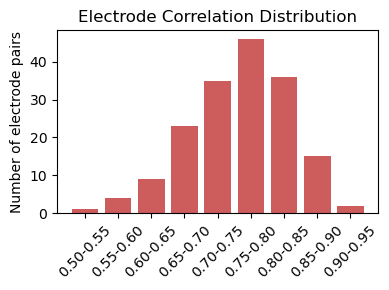

In [149]:
# .-------------------------------------- Most/least correlated electrodes -----------------------------------#
# Only need upper indices (symmetric)
upper_indices = np.triu_indices(n_channels, k=1) # Exclude diagonal -> 2D array with indices

# Extract the correlation values and sort them
corr_values = electrode_corr[upper_indices] # Extract values according to order of upper_indices (by row)
sorted_indices = np.argsort(corr_values)[::-1]  # descending order

print("Top 10 correlated electrode pairs:\n")
for idx in sorted_indices[:10]:  # Top 10 pairs
    i, j = upper_indices[0][idx], upper_indices[1][idx]
    print(f"{channels[i]:>3} - {channels[j]:<3} | Correlation: {electrode_corr[i, j]:.4f}")

print("\nBottom 10 least correlated electrode pairs:")
for idx in sorted_indices[-10:]:
    i, j = upper_indices[0][idx], upper_indices[1][idx]
    print(f"{channels[i]:>3} - {channels[j]:<3} | Corr: {electrode_corr[i, j]:.4f}")

# ----------------------- Plot distribution of correlation values -----------------------------------#


# Define bins and histogram
bins = np.arange(0.5, 0.99, 0.05)
hist, bin_edges = np.histogram(corr_values, bins=bins) # hist: counts; bin_edges: limits for bins -> label
bin_labels = [f"{bin_edges[i]:.2f}-{bin_edges[i+1]:.2f}" for i in range(len(hist))]

# Plot
plt.figure(figsize=(4, 3))
plt.bar(bin_labels, hist, color="indianred")
plt.xticks(rotation=45)
plt.ylabel("Number of electrode pairs")
plt.title("Electrode Correlation Distribution")
plt.tight_layout()
plt.show()


Top 10 correlated feature pairs:

hj_mob - spec_ent | Correlation: 0.8556
beta_pow - gamma_pow | Correlation: 0.8206
linelen - gamma_pow | Correlation: 0.7932
linelen - beta_pow | Correlation: 0.7420
alpha_pow - theta_pow | Correlation: 0.7044
hj_mob - hj_cmp | Correlation: 0.7029
rms - theta_pow | Correlation: 0.6949
linelen - hj_mob | Correlation: 0.6798
rms - alpha_pow | Correlation: 0.5789
linelen - alpha_pow | Correlation: 0.5742

Bottom 10 least correlated feature pairs:
beta_pow - rel_alpha | Corr: 0.0494
rms - theta_alpha_ratio | Corr: 0.0410
theta_pow - rel_alpha | Corr: 0.0396
hj_cmp - rel_alpha | Corr: 0.0344
hj_cmp - alpha_pow | Corr: 0.0343
rms - rel_theta | Corr: 0.0235
rms - spec_ent | Corr: 0.0185
gamma_pow - rel_alpha | Corr: 0.0160
beta_pow - rel_theta | Corr: 0.0108
hj_cmp - theta_pow | Corr: 0.0066


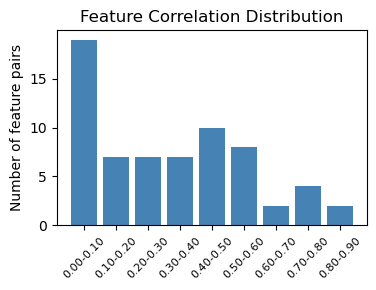

In [150]:
# .-------------------------------------- Most/least correlated features -----------------------------------#
# Only need upper indices (symmetric)
upper_indices = np.triu_indices(n_features, k=1) # Exclude diagonal -> 2D array with indices

# Extract the correlation values and sort them
corr_values = np.abs(feature_corr)[upper_indices] # Extract values according to order of upper_indices (by row)
sorted_indices = np.argsort(corr_values)[::-1]  # descending order

print("Top 10 correlated feature pairs:\n")
for idx in sorted_indices[:10]:  # Top 10 pairs
    i, j = upper_indices[0][idx], upper_indices[1][idx]
    print(f"{features[i]:>3} - {features[j]:<3} | Correlation: {abs(feature_corr[i, j]):.4f}")

print("\nBottom 10 least correlated feature pairs:")
for idx in sorted_indices[-10:]:
    i, j = upper_indices[0][idx], upper_indices[1][idx]
    print(f"{features[i]:>3} - {features[j]:<3} | Corr: {abs(feature_corr[i, j]):.4f}")

# ----------------------- Plot distribution of correlation values -----------------------------------#


# Define bins and histogram
bins = np.arange(0, 0.99, 0.1)
hist, bin_edges = np.histogram(corr_values, bins=bins)
bin_labels = [f"{bin_edges[i]:.2f}-{bin_edges[i+1]:.2f}" for i in range(len(hist))]

# Plot
plt.figure(figsize=(4, 3))
plt.bar(bin_labels, hist, color="steelblue")
plt.xticks(rotation=45, fontsize=8 )
plt.ylabel("Number of feature pairs")
plt.title("Feature Correlation Distribution")
plt.tight_layout()
plt.show()


**Insights**

- **High correlation across all electrodes (most > 0.7): feature profiles are very similar across samples**:

    - **Strongest correlated Pairs:** highest correlations are generally observed between electrodes that are **spatially close** on the scalp (e.g., FZ-CZ, CZ-PZ) or located **symmetrically over homologous brain regions** in the two hemispheres (e.g., F7-F8, P3-P4).

    - **Weakest correlated Pairs:** least correlated pairs typically involve electrodes that are **spatially distant** on the scalp (e.g., FP1-O2, FP1-PZ) or located over brain regions with more **distinct functional roles** (e.g., frontal vs. occipital). The lower correlation suggests that these electrodes capture more independent aspects of brain electrical activity.
    
- **Feature type correlation much more heterogeneous**
    - Most features have low correlation.
    - Indicates that certain EEG characteristics tend to co-vary, while others are more independent.

    -**Strongest correlated pairs**
        -  `hj_mob`, `spec_ent` : reflect signal complexity and variability.
        - `beta_pow`, `gamma_pow`, `linelen` : related to high-frequency activity and signal irregularity.
        - `rms`, `theta_pow`, **`alpha_pow` : low-frequency bands often contribute most of the signal power; so if they increase, rms also expected to do so.
        - `hj_mob` and`hj_cmp` : Expected as both are Hjorth parameters

    - **Weakest correlated pairs**: suggesting complementarity
        - Power features and relative features ( `beta_pow` and `rel_theta`, `rms` and `theta_alpha_ratio` etc...)
        - `hj_cmp` and band powers
        -  `rms` and `spec_ent`




  



- Since using Random Forest and XGBoost:
    - Less sensitive to correlation than linear models:
         - Tree-based models (Random Forest, XGBoost, LightGBM) handle feature correlation much better than models like logistic regression.
         - They split importance across correlated features: so the model still performs well, but feature importance scores get diluted.

In [157]:
# ----------------------------- RandomForest classifier with feautures filtered by correlation value -------------#

#  Compute feature correlation matrix
corr_matrix = np.corrcoef(X, rowvar=False)

# Create mask to drop highly correlated features
upper = np.triu(corr_matrix, k=1)
threshold = 0.85
to_drop = set()

for i in range(upper.shape[0]):
    for j in range(i+1, upper.shape[1]):
        if np.abs(corr_matrix[i, j]) > threshold:
            to_drop.add(j)  # Drop one of the correlated features

#  Keep only uncorrelated features
keep_indices = [i for i in range(X.shape[1]) if i not in to_drop]
X_uncorrelated = X[:, keep_indices]
print(f"Shape before removing correlated features: {X.shape}")
print(f"Shape after removing correlated features: {X_uncorrelated.shape}")

# Step 5: Train your model
model = RandomForestClassifier(n_estimators=400, max_depth=8, random_state=random_state)

f1, std = model_evaluation(
    model,
    X=X_uncorrelated,
    y=y,
    n_features=X_uncorrelated.shape[1],
    n_splits=5,
    oversampler=True,
    random_state=random_state,
    return_importances=False,
    show_matrix=False
)


Shape before removing correlated features: (12993, 228)
Shape after removing correlated features: (12993, 152)


CV folds: 100%|██████████| 5/5 [05:22<00:00, 64.43s/it]

 F1: 0.8197 ± 0.0087


- Even dropping 73 features, model maintains same performance.

### Obtaining features with statistically signficant mean differences between seizure vs non-seizure groups

In [153]:

# One p-value to test each feature combination
p_values = np.zeros((19, 12))

#  ------------------- Welch's t-test for unequal variances --------------------------------------------#
for i in range(19):      # electrodes
    for j in range(12):  # features
        s_vals = seizure_X[:, i, j]
        n_vals = non_seizure_X[:, i, j]
        _, p = ttest_ind(s_vals, n_vals, equal_var=False) #  Comparing the distribution of feature values for seixure vs non-seizure
        p_values[i, j] = p



# --------------------- Correcting for multiple comparisons -----------------------------------------#
# Flatten p-values array -> multipletests expects 1D array
p_flat = p_values.flatten()
_, p_adj, _, _ = multipletests(p_flat, method="fdr_bh")
# Reshape back
p_values_corrected = p_adj.reshape(19, 12)


# Filter features according to statistical significance
significant_mask = p_values_corrected < 0.05  # boolean mask



<Figure size 1200x600 with 0 Axes>

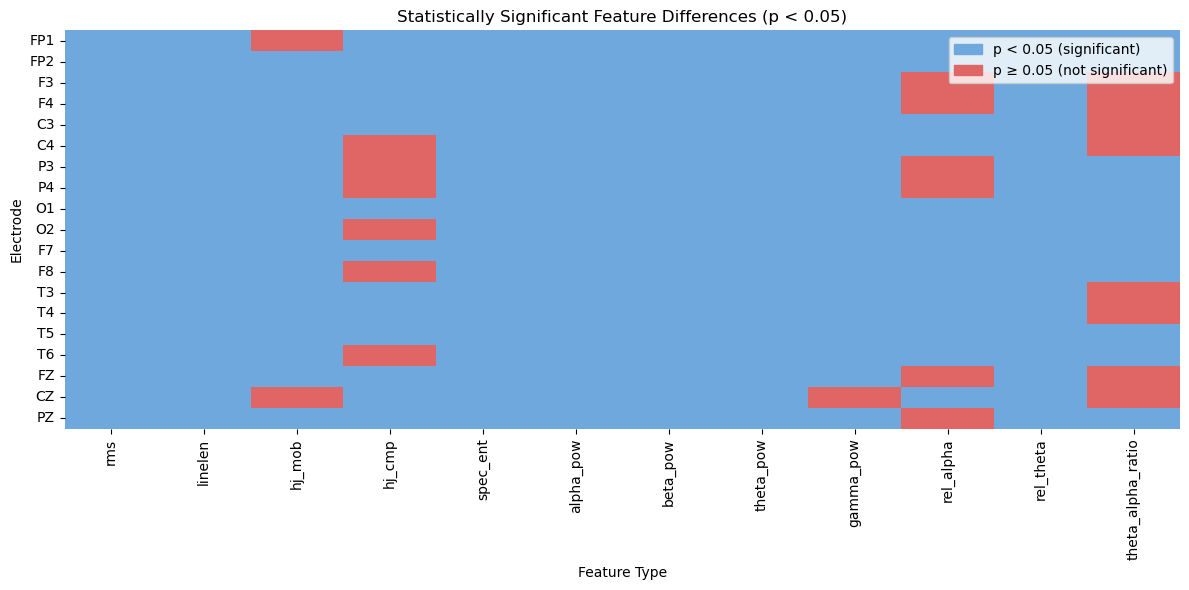

In [154]:

# ------------------------- Visusalization of statistically significant features -----------------------#


plt.figure(figsize=(12, 6))
cmap = sns.color_palette(["#e06666", "#6fa8dc"]) # First color (False) -> Blue/Significant

plt.figure(figsize=(12, 6))
ax = sns.heatmap(
    significant_mask,
    xticklabels=features,
    yticklabels=channels,
    cmap=cmap,
    cbar=False
)

# Custom legend
legend_patches = [
    mpatches.Patch(color="#6fa8dc", label="p < 0.05 (significant)"),
    mpatches.Patch(color="#e06666", label="p ≥ 0.05 (not significant)")
]
plt.legend(handles=legend_patches, loc="upper right")

plt.title("Statistically Significant Feature Differences (p < 0.05)")
plt.xlabel("Feature Type")
plt.ylabel("Electrode")
plt.tight_layout()
plt.show()


### Performance on RandomForest with filtered features according to statistical significance

- Same performance

In [ ]:
# ttest

# Apply the boolean mask (broadcasts across samples)
X_filtered = X_reshaped[:, significant_mask]

# Confirm shape
print("Filtered X shape:", X_filtered.shape) 
n_features_filtered = X_filtered.shape[1]

model = RandomForestClassifier(n_estimators=400, max_depth=8, random_state=random_state)

f1, std = model_evaluation(
    model,
    X=X_filtered,
    y=y,
    n_features=n_features_filtered,
    n_splits=5,
    oversampler=True,
    random_state=random_state,
    return_importances=False,
    show_matrix=False
)

Filtered X shape: (12993, 205)


CV folds: 100%|██████████| 5/5 [05:37<00:00, 67.50s/it]

 F1: 0.8306 ± 0.0085
